2023-12-17 18:23:13.670885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 18:23:13.670932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 18:23:13.672064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 18:23:14.679047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-17 18:23:16.929594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at 

1/1 [==============================] - 1s 555ms/step


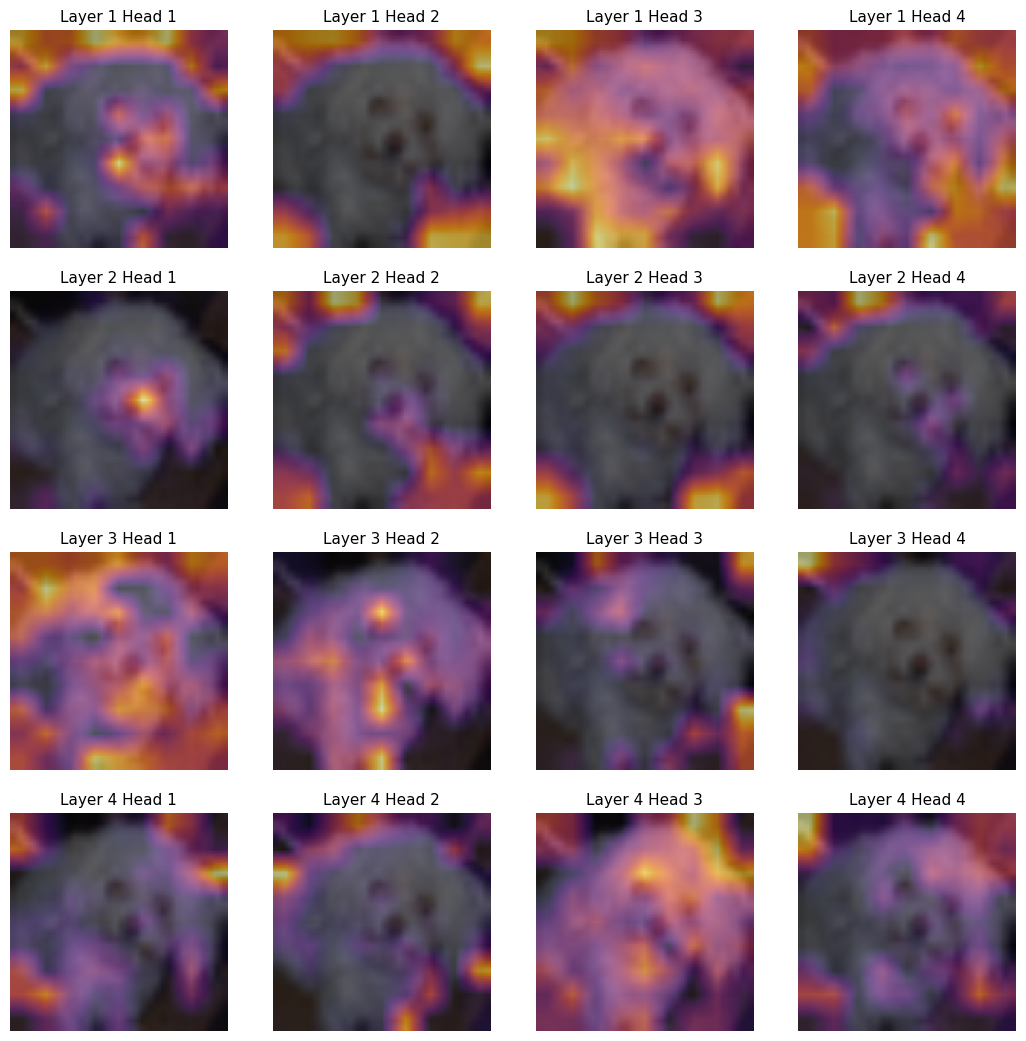

In [1]:
import keras
from keras.datasets import cifar10
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#Hyperparameters
INPUT_SHAPE = (32, 32, 3)
IMAGE_SHAPE = (75, 75)
NUM_CLASSES = 10

BATCH_SIZE = 16
EPOCHS = 2

PATCH_SIZE = (8, 8)
PROJECTION_DIM = 64
NUM_PATCHES =  (IMAGE_SHAPE[0] // PATCH_SIZE[0]) * (IMAGE_SHAPE[1] // PATCH_SIZE[1])

NUM_LAYERS = 4
NUM_HEADS = 4

TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]

MLP_HEADS_UNITS = [2048, 1024]

# Load the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train/255
x_test = x_test/255

image = x_test[1000]

# Define the model
 ## mlp
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
 ## Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(75, 75),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Patch creation layer
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = (1,patch_size[0],patch_size[1],1)

    def call(self, images):
        patches = tf.image.extract_patches(images, sizes=self.patch_size, strides=self.patch_size, rates=(1, 1, 1, 1), padding='VALID')
        patches = layers.Reshape((9 * 9, -1))(patches)
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
    
## Patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim
        self.num_patches = num_patches

    def build(self, input_shape):
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection_dim})
        return config
    
## Create the ViT model
def create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, num_classes, transformer_units, mlp_heads_units, num_heads, num_layers):
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_heads_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = create_vit_classifier(input_shape=INPUT_SHAPE, patch_size=PATCH_SIZE, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, num_classes=NUM_CLASSES, transformer_units=TRANSFORMER_UNITS, mlp_heads_units=MLP_HEADS_UNITS, num_heads=NUM_HEADS, num_layers=NUM_LAYERS)
model.load_weights('vit_cifar10.weights.h5')

# Get the sub-models for each layer
outputs = []
for i in range(NUM_LAYERS):
    submodel = keras.Model(inputs=model.input, outputs=model.layers[4+i*9].output)
    attention_layer = model.layers[5+i*9]
    attention_input = submodel.predict(image.reshape(1,32,32,3))
    _, attention_scores = attention_layer(attention_input,attention_input, return_attention_scores=True)
    attention_scores = np.reshape(attention_scores[0,:,0,:], (NUM_HEADS, 9, 9))
    
    attention_scores = np.transpose(attention_scores, (1, 2, 0)) # (9, 9, NUM_HEADS)
    attention_scores = tf.image.resize(attention_scores, (75, 75))
    outputs.append(attention_scores)


image = tf.image.resize(image, (75, 75))

# Plot the attention maps
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(13, 13))

for i in range(NUM_LAYERS):
    layer_attentions = outputs[i]
    for j in range(NUM_HEADS):
        axes[i][j].imshow(image)
        axes[i][j].imshow(layer_attentions[:,:,j], cmap='inferno', alpha=0.6)
        axes[i][j].set_title(f'Layer {i+1} Head {j+1}', fontsize=11)
        axes[i][j].axis('off')
